* Input: embeddings in `io/` directory.
* Output: graphs

In [1]:
import json
from pathlib import Path
from ast import literal_eval
from typing import Tuple, Union, List
import numpy as np
import pandas as pd

import stats
import sys

In [2]:
n = 30
noise = "human"
DIR = Path("io/2021-02-16/")

In [3]:
EM_DIR = DIR / "embeddings"
RESPONSES_DIR = DIR / "responses"
SALMON_DIR = Path.home() / "Developer" / "stsievert" / "salmon"
sys.path.append(str(SALMON_DIR / "examples"))

In [4]:
def _literal_eval(x):
    try:
        return literal_eval(x)
    except ValueError:
        return x

def _get_dict(s: str) -> dict:
    k_v = [kv.split("=") for kv in s.split("-")]
    k_v2 = {k: _literal_eval(v) for k, v in k_v}
    return k_v2

def _ident(d: dict) -> str:
    d2 = sorted(tuple(d.items()))
    d3 = [f"{k}={v}" for k, v in d2]
    return "-".join(d3)

In [5]:
import msgpack
def _get_config(name):
    return _get_dict(
        name.replace(".msgpack", "")
        .replace(".csv", "")
        .replace("responses*", "")
    )

def _get(file: Path, history=False) -> Union[Tuple[np.ndarray, dict], List[dict]]:
    with open(file, "rb") as f:
        data = msgpack.load(f)
    em = data.pop("embedding")
    meta = data.pop("meta")
    perf = data.pop("performance")
    if history:
        return data["history"]
    for k, v in perf.items():
        meta[f"perf__{k}"] = v
    return em, meta

files = list(EM_DIR.glob("*.msgpack"))
print(len(files))
data = [_get(f) for f in files]
print(len(data))

156
156


In [6]:
keys = [k for k in RESPONSES_DIR.glob("*.csv") if "alg=RandomSampling" in str(k)]
assert len(keys) == 1, len(keys)
random_responses = pd.read_csv(keys[0])
from sklearn.model_selection import train_test_split
_, df_test = train_test_split(random_responses, test_size=0.2, random_state=42)
print(keys)
X_test = df_test[["head", "winner", "loser"]].to_numpy()

from run import _X_test
X_test = _X_test(n=n, num=20_000, noise=noise)

perf = [{**meta, **stats.collect(embedding, X_test)} for embedding, meta in data]
len(perf)

[PosixPath('io/2021-02-16/responses/responses*R=10-alg=RandomSampling-d=2-dataset=alien_eggs-init=True-max_queries=100100-n=30-n_users=10-noise=human-random_state=42-reaction_time=0.25-response_time=1.0.csv')]


156

In [7]:
import datasets

In [8]:
df = pd.DataFrame(perf)

# fname = "history*R=10-alg=RR-d=2-dataset=strange_fruit-init=True-max_queries=20000-n=100-n_users=4-noise=constant-random_state=42-reaction_time=0.25-response_time=1.0.csv"
# fname = "history*R=10-alg=RR-d=2-dataset=strange_fruit-init=True-max_queries=20100-n=30-n_users=6-noise=constant-random_state=42-reaction_time=0.25-response_time=1.0.csv"
# fname = "history*R=10-alg=RR-d=2-dataset=alien_eggs-init=True-max_queries=30100-n=50-n_users=6-noise=human-random_state=42-reaction_time=0.25-response_time=1.0.csv"
fname = "history*R=10-alg=RR-d=2-dataset=alien_eggs-init=True-max_queries=30100-n=30-n_users=10-noise=human-random_state=42-reaction_time=0.25-response_time=1.0.csv"
online = pd.read_csv(DIR / "history" / fname)
online["alg"] = online["perf__ident"] = "RR (online)"

df["sampling"] = df.ident.apply(lambda s: s.split("-")[0])
df["embedding"] = df.ident.apply(lambda s: s.split("-")[1])
online["sampling"] = "online"
online["embedding"] = "online"
df = pd.concat((df, online))
print("df.shape =", df.shape)

df.head()

df.shape = (207, 65)


,noise_model,responses*R,alg,d,dataset,init,max_queries,n,n_users,noise,...,nn_diff_p10,nn_diff_p5,nn_diff_p1,embedding_error,embedding_rel_error,procrustes_disparity,sampling,embedding,Unnamed: 0,R
0,CKL,10.0,RR,2,alien_eggs,True,30100,30,10,human,...,1.0,1.0,1.0,0.057470,0.057470,0.003303,active,CKL,NaN,NaN
1,CKL,10.0,RR,2,alien_eggs,True,30100,30,10,human,...,1.0,1.0,1.0,0.025229,0.025229,0.000637,active,CKL,NaN,NaN
2,NaN,10.0,RandomSampling,2,alien_eggs,True,100100,30,10,human,...,1.0,1.0,1.0,0.180204,0.180204,0.032474,random,SOE,NaN,NaN
3,GNMDS,10.0,RR,2,alien_eggs,True,30100,30,10,human,...,1.0,1.0,1.0,0.433235,0.433235,0.187693,active,GNMDS,NaN,NaN
4,NaN,10.0,RandomSampling,2,alien_eggs,True,100100,30,10,human,...,1.9,1.0,1.0,0.359765,0.359765,0.129431,random,TSTE,NaN,NaN


In [9]:
df.alg.unique()

array(['RR', 'RandomSampling', 'RR (online)'], dtype=object)

In [10]:
df.columns

Index(['noise_model', 'responses*R', 'alg', 'd', 'dataset', 'init',
       'max_queries', 'n', 'n_users', 'noise', 'random_state', 'reaction_time',
       'response_time', 'ident', 'est__noise_model', 'est__shuffle',
       'est__max_epochs', 'est__dwell', 'n_train', 'n_test', 'n_responses',
       'perf__pf_calls', 'perf__num_answers', 'perf__model_updates',
       'perf__num_grad_comps', 'perf__answers_bytes', 'perf__score_train',
       'perf__loss_train', 'perf__k', 'perf__elapsed_time', 'perf__train_data',
       'perf__n', 'perf__d', 'perf__max_epochs', 'perf__verbose',
       'perf__ident', 'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_e

(0.0, 20.0)

(0.0, 20.0)

(0.0, 20.0)

(0.0, 20.0)

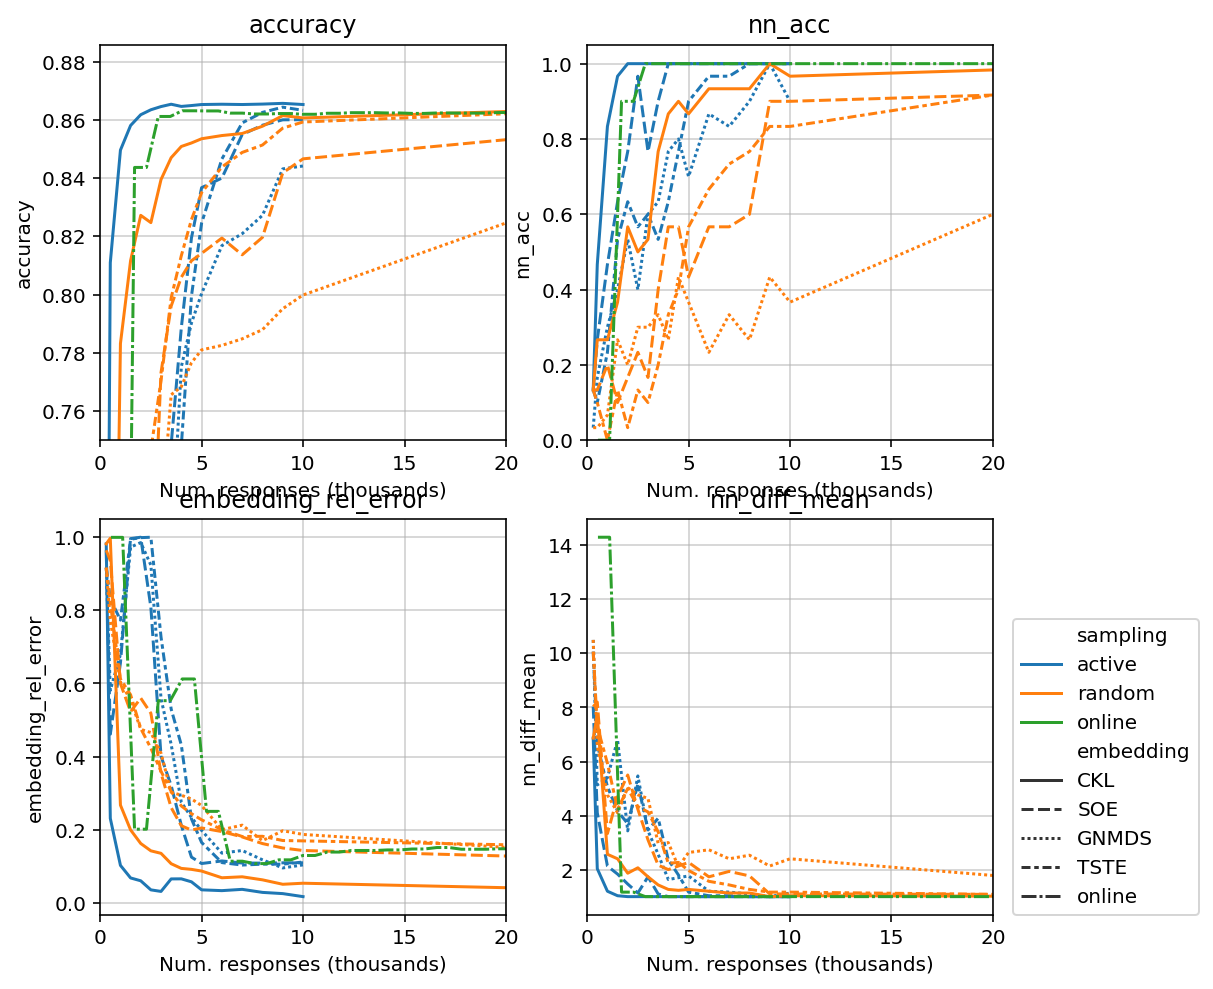

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

df["n_responses/1000"] = df.n_responses / 1000
Y = ["accuracy", "nn_acc", "embedding_rel_error", "nn_diff_mean"]
# Y = ["accuracy", "perf__loss_test", "embedding_rel_error", "nn_diff_mean"]

w = 4
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2 * w, 2.0 * w))
for k, (y, ax) in enumerate(zip(Y, axs.flatten())):
    ax = sns.lineplot(
        x="n_responses/1000",
        y=y,
        hue="sampling",
        style="embedding",
#         marker="o",
#         data=df,
        data=df,#[df.embedding.isin(["online", "CKL"])],
        ax=ax,
    )
    _ = ax.set_xlabel("Num. responses (thousands)")
    ax.grid(alpha=0.6)
    if k != 3:
        ax.legend_.remove()
    else:
        ax.legend(loc=(1.05, 0))
    _ = ax.set_title(y)
    
#     ax.set_xscale("log")
    if "accu" in y:
        _ = ax.set_ylim(0.75, None)
    elif "nn_acc" in y:
        _ = ax.set_ylim(0.0, 1.05)
    ax.set_xlim(0, 20)
#     ax.set_xlim(0.2, 20)


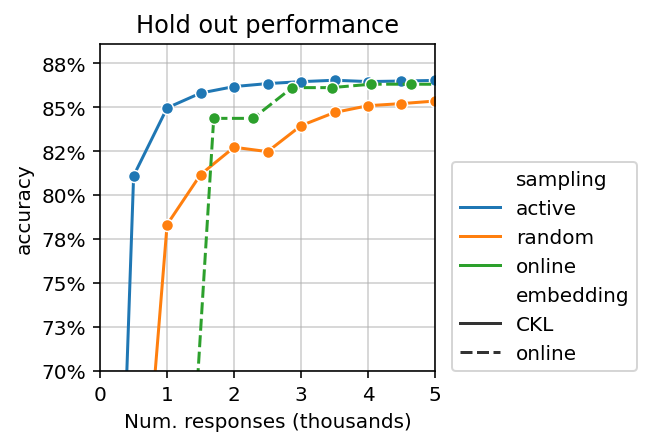

In [24]:
import matplotlib.ticker as ticker
show = df[df.embedding.isin(["online", "CKL"])].copy()
show["error"] = 1 - show["accuracy"]

w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "accuracy"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    style="embedding",
    marker="o",
    data=show,
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(0, 5)

_ = ax.set_ylim(0.70, None)
_ = ax.set_title("Hold out performance")

ax.legend(loc=(1.05, 0))

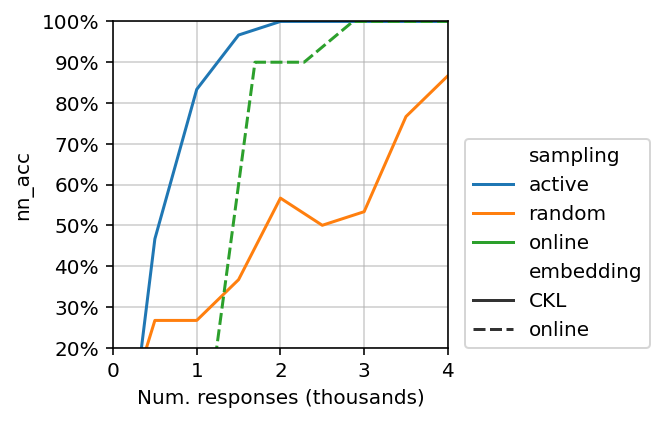

In [28]:
w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "nn_acc"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    style="embedding",
    data=show,
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(0, 4)

_ = ax.set_ylim(0.20, 1.0)

ax.legend(loc=(1.05, 0))

Index(['noise_model', 'responses*R', 'alg', 'd', 'dataset', 'init',
       'max_queries', 'n', 'n_users', 'noise', 'random_state', 'reaction_time',
       'response_time', 'ident', 'est__noise_model', 'est__shuffle',
       'est__max_epochs', 'est__dwell', 'n_train', 'n_test', 'n_responses',
       'perf__pf_calls', 'perf__num_answers', 'perf__model_updates',
       'perf__num_grad_comps', 'perf__answers_bytes', 'perf__score_train',
       'perf__loss_train', 'perf__k', 'perf__elapsed_time', 'perf__train_data',
       'perf__n', 'perf__d', 'perf__max_epochs', 'perf__verbose',
       'perf__ident', 'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_e

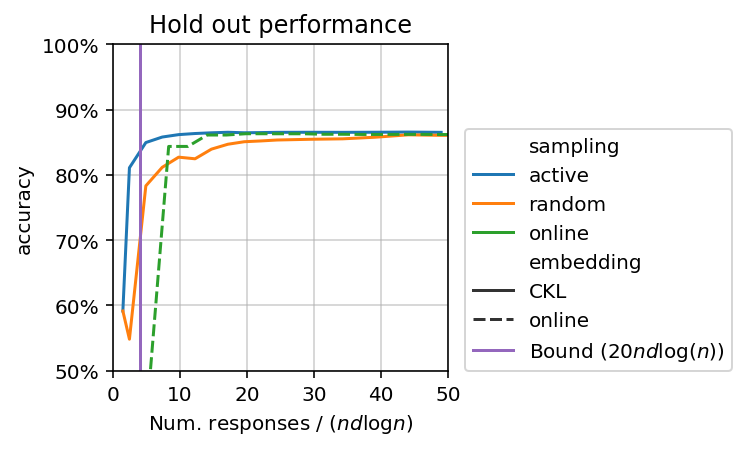

In [26]:
import matplotlib.ticker as ticker
show = df[df.embedding.isin(["online", "CKL"])].copy()
show["error"] = 1 - show["accuracy"]

prob = show["n"] * show["d"] * np.log(show["n"])
show["n_responses/prob"] = show["n_responses"] / prob
print(show.columns)
assert np.allclose(show["n"], show["n"].iloc[0])
assert np.allclose(show["d"], show["d"].iloc[0])
n, d = show["n"].iloc[0], show["d"].iloc[0]

w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "accuracy"
ax = sns.lineplot(
    x="n_responses/prob",
    y=y,
    hue="sampling",
    style="embedding",
    data=show,
)

bound = 20 * n * d * np.log(n) / 1000
ax.plot([bound, bound], [0, 1], "C4", label="Bound $(20nd\log(n))$")

ax.set_xlabel("Num. responses / $(nd\log n)$")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))

_ = ax.set_ylim(0.50, 1)
_ = ax.set_xlim(0, 50)
_ = ax.set_title("Hold out performance")

ax.legend(loc=(1.05, 0))

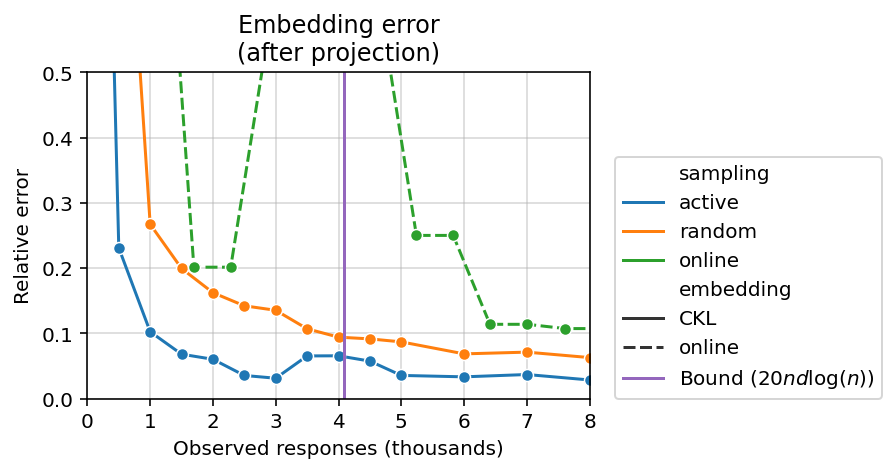

In [34]:
w = 3.0
fig, axs = plt.subplots(figsize=(1.5 * w, 1.0 * w))
y = "embedding_rel_error"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    style="embedding",
#     ci=None,
#     estimator="max",
    marker="o",
    data=show,
)
ax.grid(alpha=0.5)
ax.plot([bound, bound], [0, 1], "C4", label="Bound $(20nd\log(n))$")
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
# ax.xaxis.set_major_locator(plt.FixedLocator([0, 4, 10, 20, 30, 40, 50, 60]))
# ax.set_ylim(0.2, 1)
# ax.set_xscale("log")
# ax.set_xlim(0.5, 4)

# ax.set_xscale("log", base=2)
# ax.set_xlim(0.5, None)
ax.set_ylabel("Relative error")
ax.set_ylim(0, 0.5)
ax.set_xlim(0, 8)
ax.set_title("Embedding error\n(after projection)")
ax.set_xlabel("Observed responses (thousands)")
ax.legend(loc=(1.05, 0))

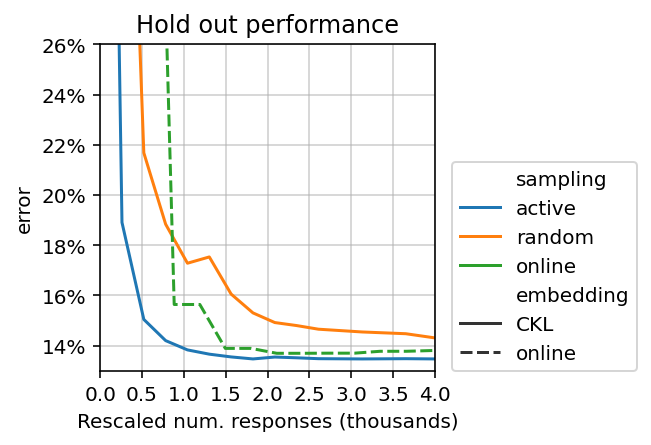

In [38]:
w = 1
fig, axs = plt.subplots(figsize=(3 * w, 3 * w))
y = "error"

s = show.copy()
n1 = 50
n2 = 30
factor = (n1 * np.log(n1)) / (n2 * np.log(n2))
s["n_responses_sim/1000"] = s["n_responses/1000"] / factor

ax = sns.lineplot(
    x="n_responses_sim/1000",
    y=y,
    hue="sampling",
    style="embedding",
#     ci=None,
#     estimator="max",
#     marker="o",
    data=s,
)
ax.set_xlabel("Rescaled num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(0, 30)
ax.set_ylim(0.13, 0.26)
# ax.set_xlim(25, 35)
# ax.set_xscale("log", base=2)

ax.set_xlim(0.00, 4)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))

# _ = ax.set_ylim(0.70, None)
_ = ax.set_title("Hold out performance")

# ax.set_xscale("log", base=2)
# ax.xaxis.set_major_locator(ticker.LogLocator(base=2, numticks=15))
# ax.set_xlim(0.3, None)
ax.legend(loc=(1.05, 0))

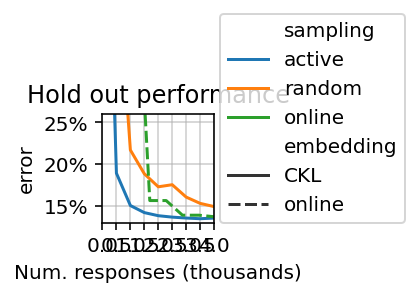

In [17]:
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "error"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    style="embedding",
#     ci=None,
#     estimator="max",
#     marker="o",
    data=show,
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.set_xlim(0, 4)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_ylim(0.13, 0.26)
# ax.set_xlim(25, 35)
# ax.set_xscale("log", base=2)

# _ = ax.set_ylim(0.70, None)
_ = ax.set_title("Hold out performance")

# ax.set_xscale("log", base=2)
# ax.xaxis.set_major_locator(ticker.LogLocator(base=2, numticks=15))
# ax.set_xlim(0.3, None)
ax.legend(loc=(1.05, 0))

In [18]:
_idx = show.pivot_table(
    index="sampling",
    values="accuracy",
    aggfunc=lambda x: np.abs(x - 0.82).idxmin(),
)
idx = {k: int(v) for k, v in dict(_idx["accuracy"]).items()}
for i in idx.values():
    s = show.loc[i, ["accuracy", "sampling", "n_responses"]]
    print(s)

accuracy       0.81095
sampling        active
n_responses        500
Name: 113, dtype: object
accuracy       0.84365
sampling        online
n_responses       1696
Name: 2, dtype: object
accuracy       0.8247
sampling       random
n_responses      2500
Name: 53, dtype: object


In [19]:
df.columns

Index(['noise_model', 'responses*R', 'alg', 'd', 'dataset', 'init',
       'max_queries', 'n', 'n_users', 'noise', 'random_state', 'reaction_time',
       'response_time', 'ident', 'est__noise_model', 'est__shuffle',
       'est__max_epochs', 'est__dwell', 'n_train', 'n_test', 'n_responses',
       'perf__pf_calls', 'perf__num_answers', 'perf__model_updates',
       'perf__num_grad_comps', 'perf__answers_bytes', 'perf__score_train',
       'perf__loss_train', 'perf__k', 'perf__elapsed_time', 'perf__train_data',
       'perf__n', 'perf__d', 'perf__max_epochs', 'perf__verbose',
       'perf__ident', 'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_e

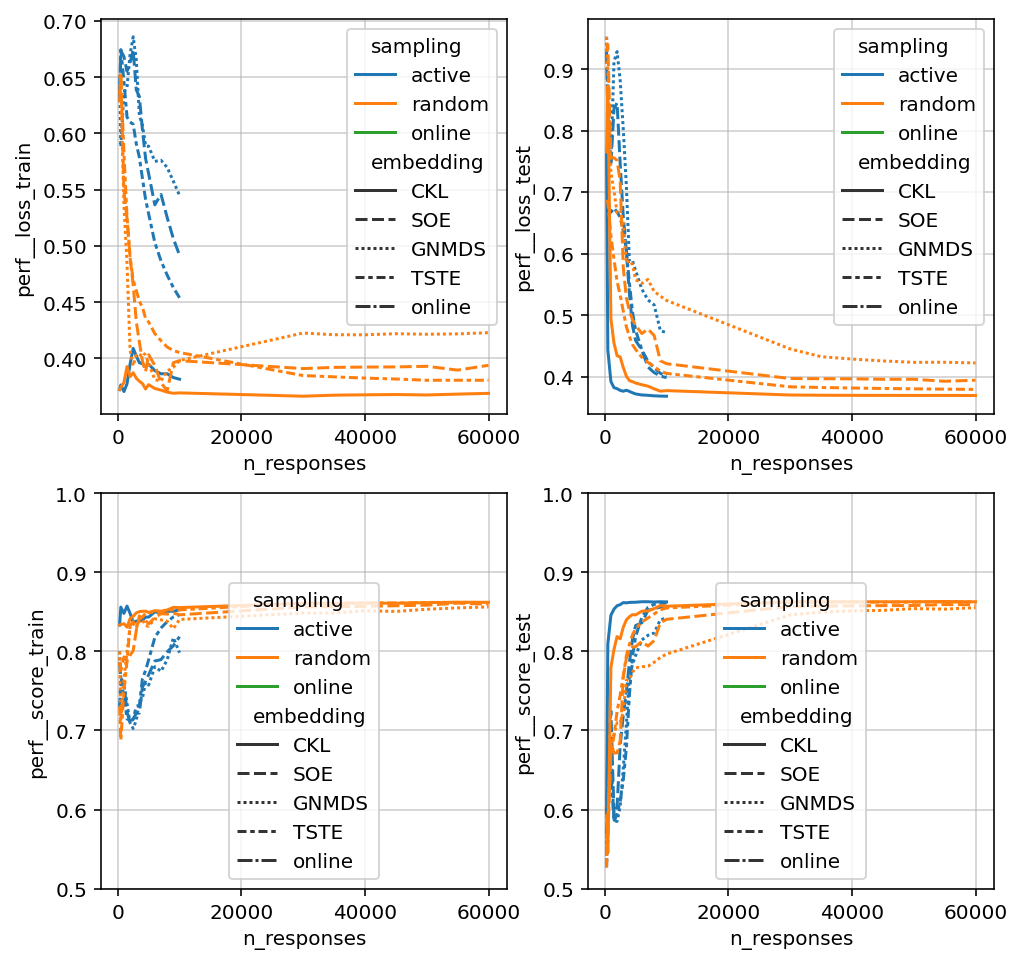

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

Y = ["accuracy", "nn_acc", "embedding_rel_error", "nn_diff_mean"]
Y = ["perf__loss_train", "perf__loss_test", "perf__score_train", "perf__score_test"]

w = 4
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2 * w, 2.0 * w))
for y, ax in zip(Y, axs.flatten()):
    ax = sns.lineplot(
        x="n_responses",
        y=y,
        hue="sampling",
        style="embedding",
        data=df,
        ax=ax,
    )
    ax.grid(alpha=0.6)
    if "score" in y:
        _ = ax.set_ylim(0.5, 1)
#     ax.set_xscale("log")
#     _ = ax.set_title(y)
# axs[0][1].set_ylim(0, 2)

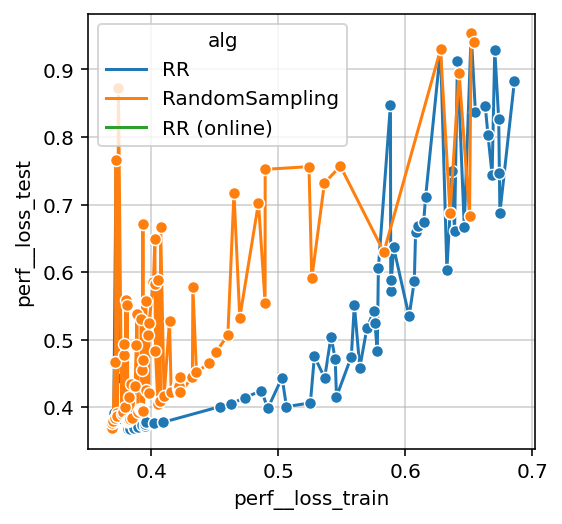

In [21]:
w = 2
fig, ax = plt.subplots(figsize=(2 * w, 2.0 * w))
ax = sns.lineplot(
    x="perf__loss_train",
    y="perf__loss_test",
    hue="alg",
    data=df,
    marker="o",
    ax=ax,
)
ax.grid(alpha=0.6)
